# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Classificator</div>

We will implement a classificator using a SVM model to extract which features or words are key to classify a tweet into real or fake.

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import html
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=10,split_factor=2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

c:\Users\elena\GitHub\MachineLearning-24-25-ProgressTasks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords

In [3]:
DATA = 'data/'
test = pd.read_csv(DATA + 'Constraint_English_Test.csv', delimiter=';', encoding='utf-8')
train = pd.read_csv(DATA + 'Constraint_English_Train.csv', delimiter=';', encoding='utf-8')
val = pd.read_csv(DATA + 'Constraint_English_Val.csv', delimiter=';', encoding='utf-8')

In [4]:
tweets = pd.concat([train, val, test], ignore_index=True)
tweets.drop(columns=['id'], inplace=True)
tweets['tweet'] = tweets['tweet'].apply(html.unescape)

In [5]:
# remove links that start with 'http' --> https://t.co/... or http://www...
import re
def filter(tweet: str):
    # https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url#3809435
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)  # remove numbers
    tweet = re.sub(r'^RT @[A-Za-z0-9_]{1,15}:', '', tweet)
    return tweet


tweets['tweet_nolinks'] = tweets['tweet'].apply(filter)

In [6]:
tweets = tweets.drop_duplicates(subset='tweet', keep='first').reset_index(drop=True)

We will use a TF-IDF representation to convert the strings representing tweets into a vector with different columns representing different tokens. The result of this will then be passed as input data for the Support Vector Machine to train on.

In [7]:
# TF-IDF initialization
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True,ngram_range=(1,2), stop_words=stopwords.words('english'), max_features=1000)

In [8]:
X = tfidf.fit_transform(tweets['tweet_nolinks'])

label_mapping = {'fake':0, 'real':1}
tweets['label_mapped'] = tweets['label'].map(label_mapping)
y = tweets['label_mapped']

In [9]:
from scipy.sparse import csr_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test:csr_matrix
X_train:csr_matrix
y_train:pd.Series
y_test:pd.Series

Instead of only training a single SVM, we will perform a random search, to find the optimal SVM between a number of them.

In [10]:
svc = SVC(probability=True)

In [11]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {'C': [10, 50, 100, 500],
              'gamma': [0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
model = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, cv = 5, verbose = 1, n_jobs = 10, scoring='f1_macro')

In [12]:
# 10 min
model.fit(X_train, y_train)

In [ ]:
import pickle

# with open('model_SVC.pkl', 'rb') as f:
#     best_model = pickle.load(f)

best_model = model.best_estimator_

print(f"""
Parameters for optimal model:
- Kernel: {model.best_params_['kernel']}
- Gamma: {model.best_params_['gamma']}
- C: {model.best_params_['C']}
""")
# with open('model_SVC.pkl', 'wb') as f:
#     pickle.dump(best_model, f)


We will now test this model:

In [14]:
y_pred = best_model.predict(X_test)

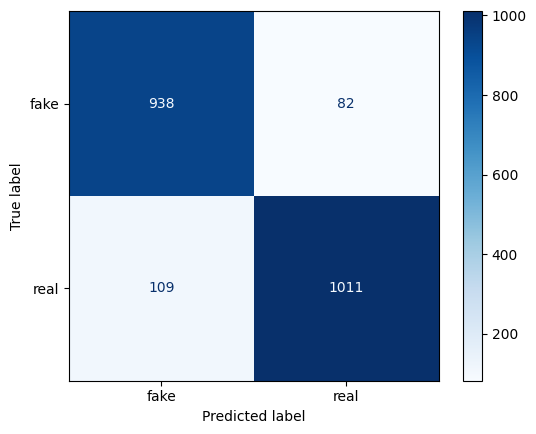

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1020
           1       0.92      0.90      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred))

As we can see, the accuracy of this model is quite high, and the confusion matrix shows promising results for the classification.

Now that we have a model able to predict whether a tweet is true or not, something we can do with it is measure how important the presence of certain tokens are to the truthfullness of said tweet.

If we assume that the model is 100% accurate, then we could use the shap library to figure out whether the different tokens present in the tweet are more or less responsible for its result. Obvioulsy in practice, the model might be wrong, so the token might be responsible for an erroneous result, but the high accuracy of the model will guarantuee us that we will have a high certainty of the importance of the aforementioned tokens.

In [17]:
import shap
shap.initjs()

In [22]:
# data = shap.sample(X_train.toarray(), 200, random_state=42)
# data = shap.kmeans(X_train.toarray(), 200)
# explainer = shap.KernelExplainer(best_model.decision_function, data, feature_names=tfidf.get_feature_names_out())

explainer = shap.SamplingExplainer(best_model.decision_function, np.zeros((1,X_test.shape[1])), feature_names=tfidf.get_feature_names_out(), output_names=['fake', 'real'], seed=42)


In [25]:
X_test[y_test == 0].shape
data_0 = shap.sample(X_test[y_test == 0].toarray(), 5, random_state=42)
data_1 = shap.sample(X_test[y_test == 1].toarray(), 5, random_state=42)
data_test = np.concatenate([data_0, data_1])

In [26]:
shap_values = explainer(pd.DataFrame(X_test.toarray(),columns=tfidf.get_feature_names_out()))


100%|██████████| 10/10 [36:31<00:00, 219.11s/it]


We can now see the impact on the model output for the different tokens on each input.

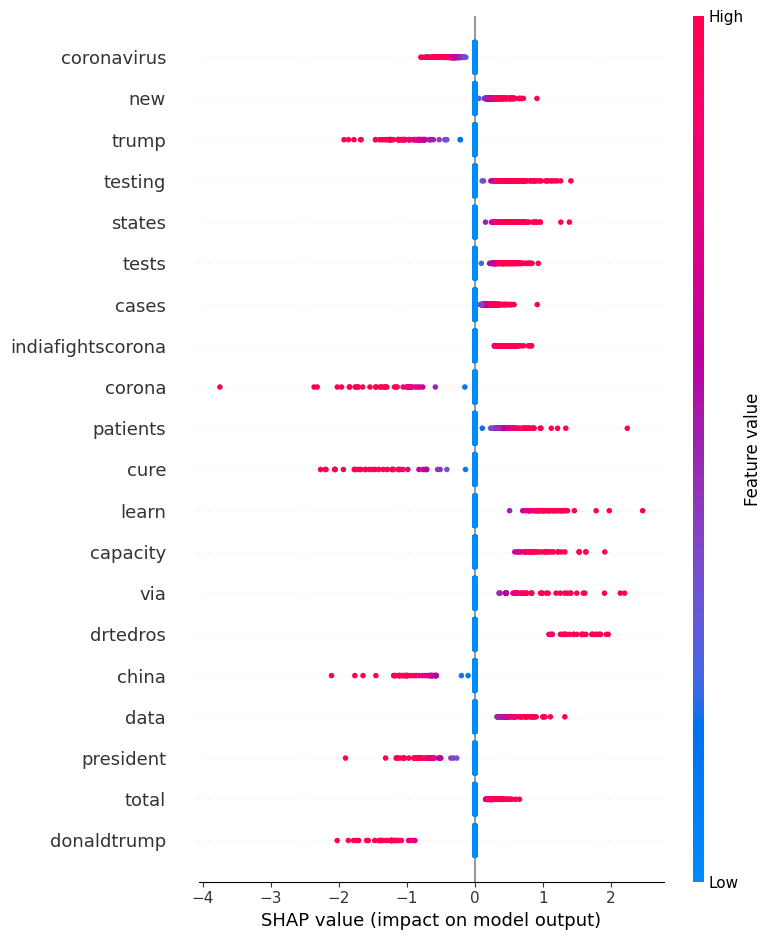

In [ ]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out()
)
# y: palabras con mayor peso en la clasificación
# colores: valor TFIDF, rojo = alto, azul = bajo
# x: clase real hacia la derecha
# ejemplo: 'china' afecta más a la clasificación de 'fake'

We can see here, as espected, that mentions of china, trump or of a "cure" (not necesarily a vaccine, but cure) tend to influence the model for a fake prediction, and thus we can conclude that they might be mentioned in fake tweets more (their presence in a tweet implies it is more likely fake)

On the othe hand, the presence of cases, testing, data, or the keyword "patients" imply the tweet is more likely fake. We can also observe the presence of the keyword, indiafightscorona, from a hashtag, that implies a high probability of truth just by its presence on the tweet. It could imply that there is a community of people in india that tend to be more careful of not being misinformed around COVID.

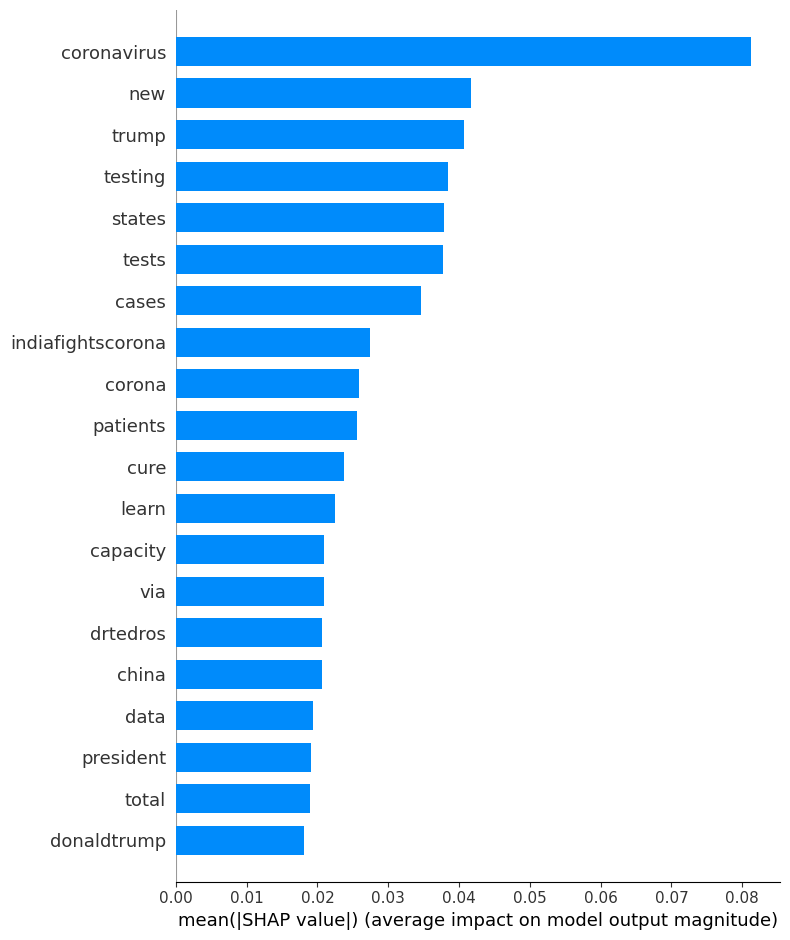

In [46]:
# Crear un bar plot
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out(), 
    plot_type="bar"
)

In [29]:
from textwrap import wrap as _wrap

def wrap(s:str, w:int = 70) -> str:
    r = ""
    for i in _wrap(s,w):
        r+=i+"\n"
    return r

token_to_column_num = {j:i for i,j in enumerate(tfidf.get_feature_names_out())}

def print_token_examples(token:str,samples = 7,width=80):
    print(f"TOKEN: \x1b[1m{token}\x1b[0m")
    examples:pd.Series[str] = (
        tweets['tweet']
        .iloc[
            (X.getcol(token_to_column_num[token]) != 0).toarray().transpose().tolist()[0]
        ]
        .sample(samples)
    )
    for num,i in examples.items():
        
        color = 31 if tweets['label_mapped'][num] == 0 else 32
        t = re.compile(re.escape(token),re.IGNORECASE).sub(f'\x1b[1m{token}\x1b[0m\x1b[{color}m',i)
        [t[i:i+50] for i in range(len(t))]
        # t = i.replace(token,f'\x1b[1m{token}\x1b[0m\x1b[{color}m')
        print(wrap(f"\x1b[{color}m{t}\x1b[0m",width))
        print(f"---")

In [165]:
print_token_examples('indiafightscorona')

TOKEN: indiafightscorona
#CoronaVirusUpdates #indiafightscorona Total recoveries cross
13.2 lakh with 46121 patients discharged in last 24 hours. The gap between
recovered patients and active #COVID19 cases is continuously rising and has
reached 732835. https://t.co/pjVz5JkZ4t

---
#indiafightscorona India has performed remarkably on
fulfilling WHO’s advise of 140 tests/day/ million population. 35 States/UTs have
crossed the advised number of tests. https://t.co/O8JG9RCb29

---
📢#CoronaVirusUpdates: 📍#COVID19 India Tracker (As on 17 September 2020
08:00 AM) ➡️Confirmed cases: 5118253 ➡️Recovered: 4025079 (78.6%)👍 ➡️Active
cases: 1009976 (19.7%) ➡️Deaths: 83198 (1.6%) #indiafightscorona
#IndiaWillWin #StaySafe Via @MoHFW_INDIA https://t.co/835SfUBIWF

---
#indiafightscorona: The vaccine developed by Russia has been
under consideration of the country. Govt of Russia approached our govt & sought
help on 2 counts- to consider its manufacturing through our network of companies
& phase 3 stu

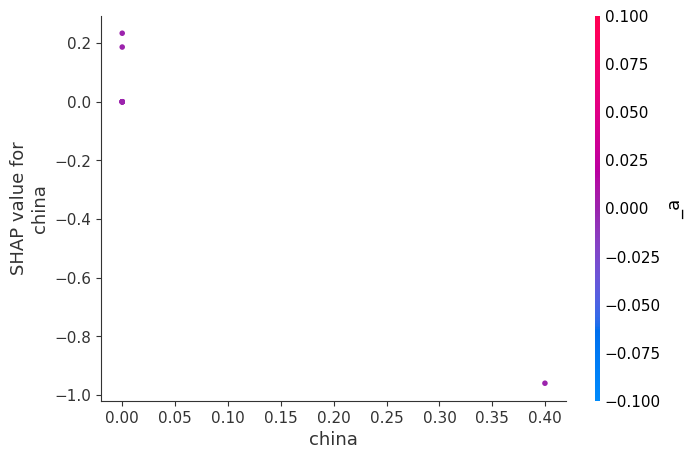

In [98]:
# Visualiza la influencia de una característica específica
shap.dependence_plot(
    "testing",  # Cambia por una característica específica
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out()
)
